# Car-Classifier III (Final Phase) 

In this notebook, we'll see how to use PyTorch to train a classifier to identify 2 different objects (images of `cars`, and `nonCars`) using classes. Through this project, we'll also get familiar with the most fundamental aspects of transfer learning, PyTorch, convolutional neural networks, and inference.

<br>
Name: James Anthony Ortiz
<br>
Course: CEN4020 - Software Engineering I
<br>
Team: ByteMyAscii
<br>
Last-Update: 10/28/2019

## Section I: Libraries and Resources

In order to use this full tutorial, we will need to first make sure we have the sufficient resources to create the program. First and foremost, the assumption is that you are currently cusing a Linux based operating system like Ubuntu. From there we will need to add the following libraries and dependencies:

- PIL (For Imaging)
- Numpy (to change the tensor back to an array)
- seaborn, and matplotlib (for Data Analysis)
- torch & torchvision (via the PyTorch website)
- cv2 (via OpenCV)
- torchsummary (via summary library)
- Pandas (also for array purposes)

From my experience, its more simpilistic to install cuda, as this will come included with most of the libraries that are used alwready. Try to avoid using pip3.


In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

## Section II: Obtaining Images From a File

The parameters in this cell can be changed as needed. I'm going to be training with only 1 gpu, but your setup will probably be different and I have added some flexibility to the source code to allow for multiple gpus for further optimization if needed. One of the benefits of using PyTorch is we can easily move different elements of the model or data to cpus/gpus or to multiple gpus. Granted, we probably won't always have many gpus, but when we do, we want to make the best use of them!

In [2]:
# Location of data
datadir = '/home/james/Desktop/NewCarAndNonCar/'
traindir = datadir + 'train/'
validdir = datadir + 'validate/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 30

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')


Train on gpu: False


In [3]:
# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False



## Section III: Data Exploration

We can do a brief exploration of the available images. There are a total of 2 categories, which I've already split into training (50%), validation (25%), and testing (25%) folders. The data is clean and each class (I use the terms "class" and "category" interchangeably in this notebook) is stored in a separate folder. The architecture of the folders is thus:

/datadir<br>
    /train<br>
            /class_1<br>
            /class_2<br>
            .<br>
            .<br>
    /valid<br>
            /class_1<br>
            /class_2<br>
            .
            .
    /test<br>
            /class_1<br>
            /class_2<br>
            .
            .

,category,n_train,n_valid,n_test
1,car,980,502,472
0,nonCar,56,119,89


,category,n_train,n_valid,n_test
1,car,980,502,472
0,nonCar,56,119,89


(array([0, 1]), <a list of 2 Text xticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

height                                                           \
          count        mean        std   min    25%    50%    75%    max   
category                                                                   
car       980.0  268.035714  78.020346  75.0  250.0  250.0  250.0  600.0   
nonCar     56.0   79.660714  15.973019  51.0   65.0   77.5   96.0   96.0   

          width                                                            
          count        mean        std    min    25%    50%    75%    max  
category                                                                   
car       980.0  397.783673  94.699752  100.0  376.0  376.0  376.0  800.0  
nonCar     56.0   87.678571  13.230965   48.0   78.0   96.0   96.0   96.0

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

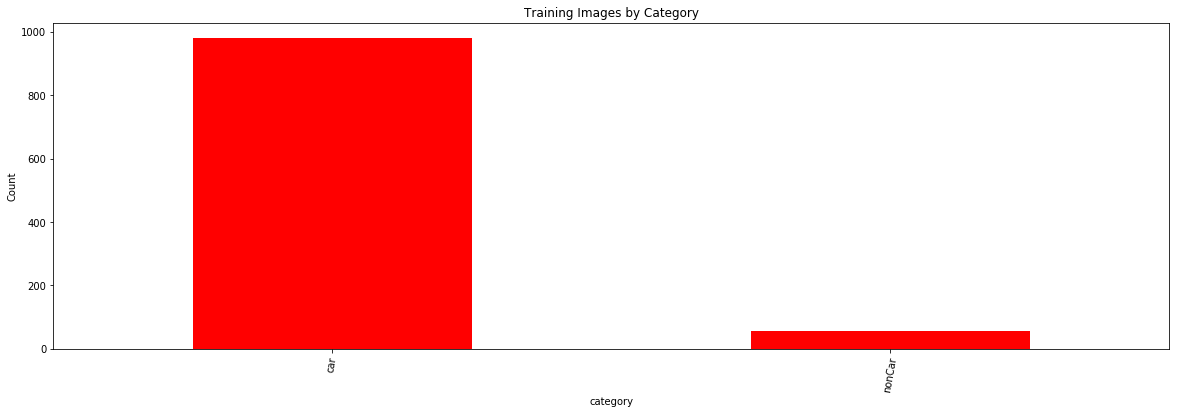

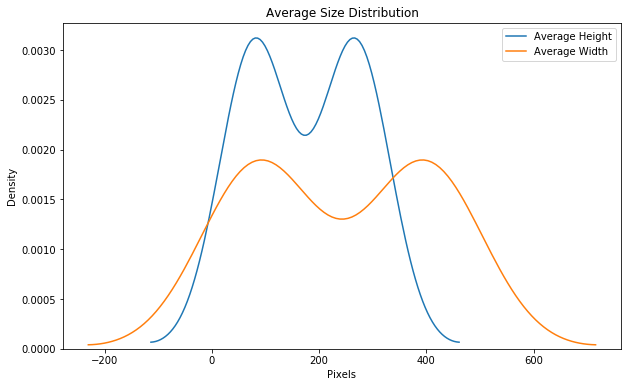

In [4]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()


#Distribution of Images

cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

#Size Distribution:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated.


### A function for image display:

(600, 800, 3)

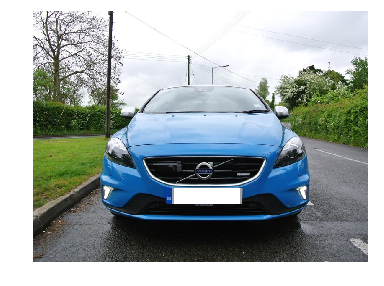

In [5]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open(traindir + 'car/car335.jpg')
np.array(x).shape
imshow(x)

(287, 460, 3)

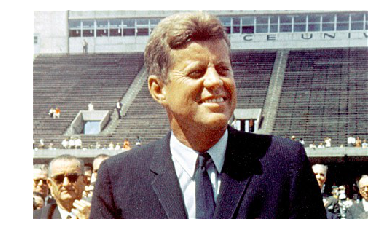

In [6]:
x = Image.open(testdir + 'nonCar/notcar34.jpg')
np.array(x).shape
imshow(x)

## Section IV: Data Augmentation

Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch Tensors before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for `Imagenet`.

In [7]:

#Data Augmentation: 

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


### An Example of Augmentation

In order to demonstrate how augmentation works, we need to write a function that will plot a tensor as an image.

In [8]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image


We'll test this function with one image and apply the train transformations:

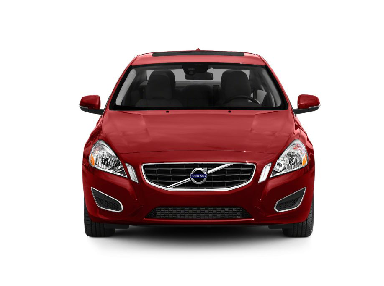

In [9]:
ex_img = Image.open(traindir + 'car/car334.jpg')
imshow(ex_img)

<Figure size 1728x1728 with 0 Axes>

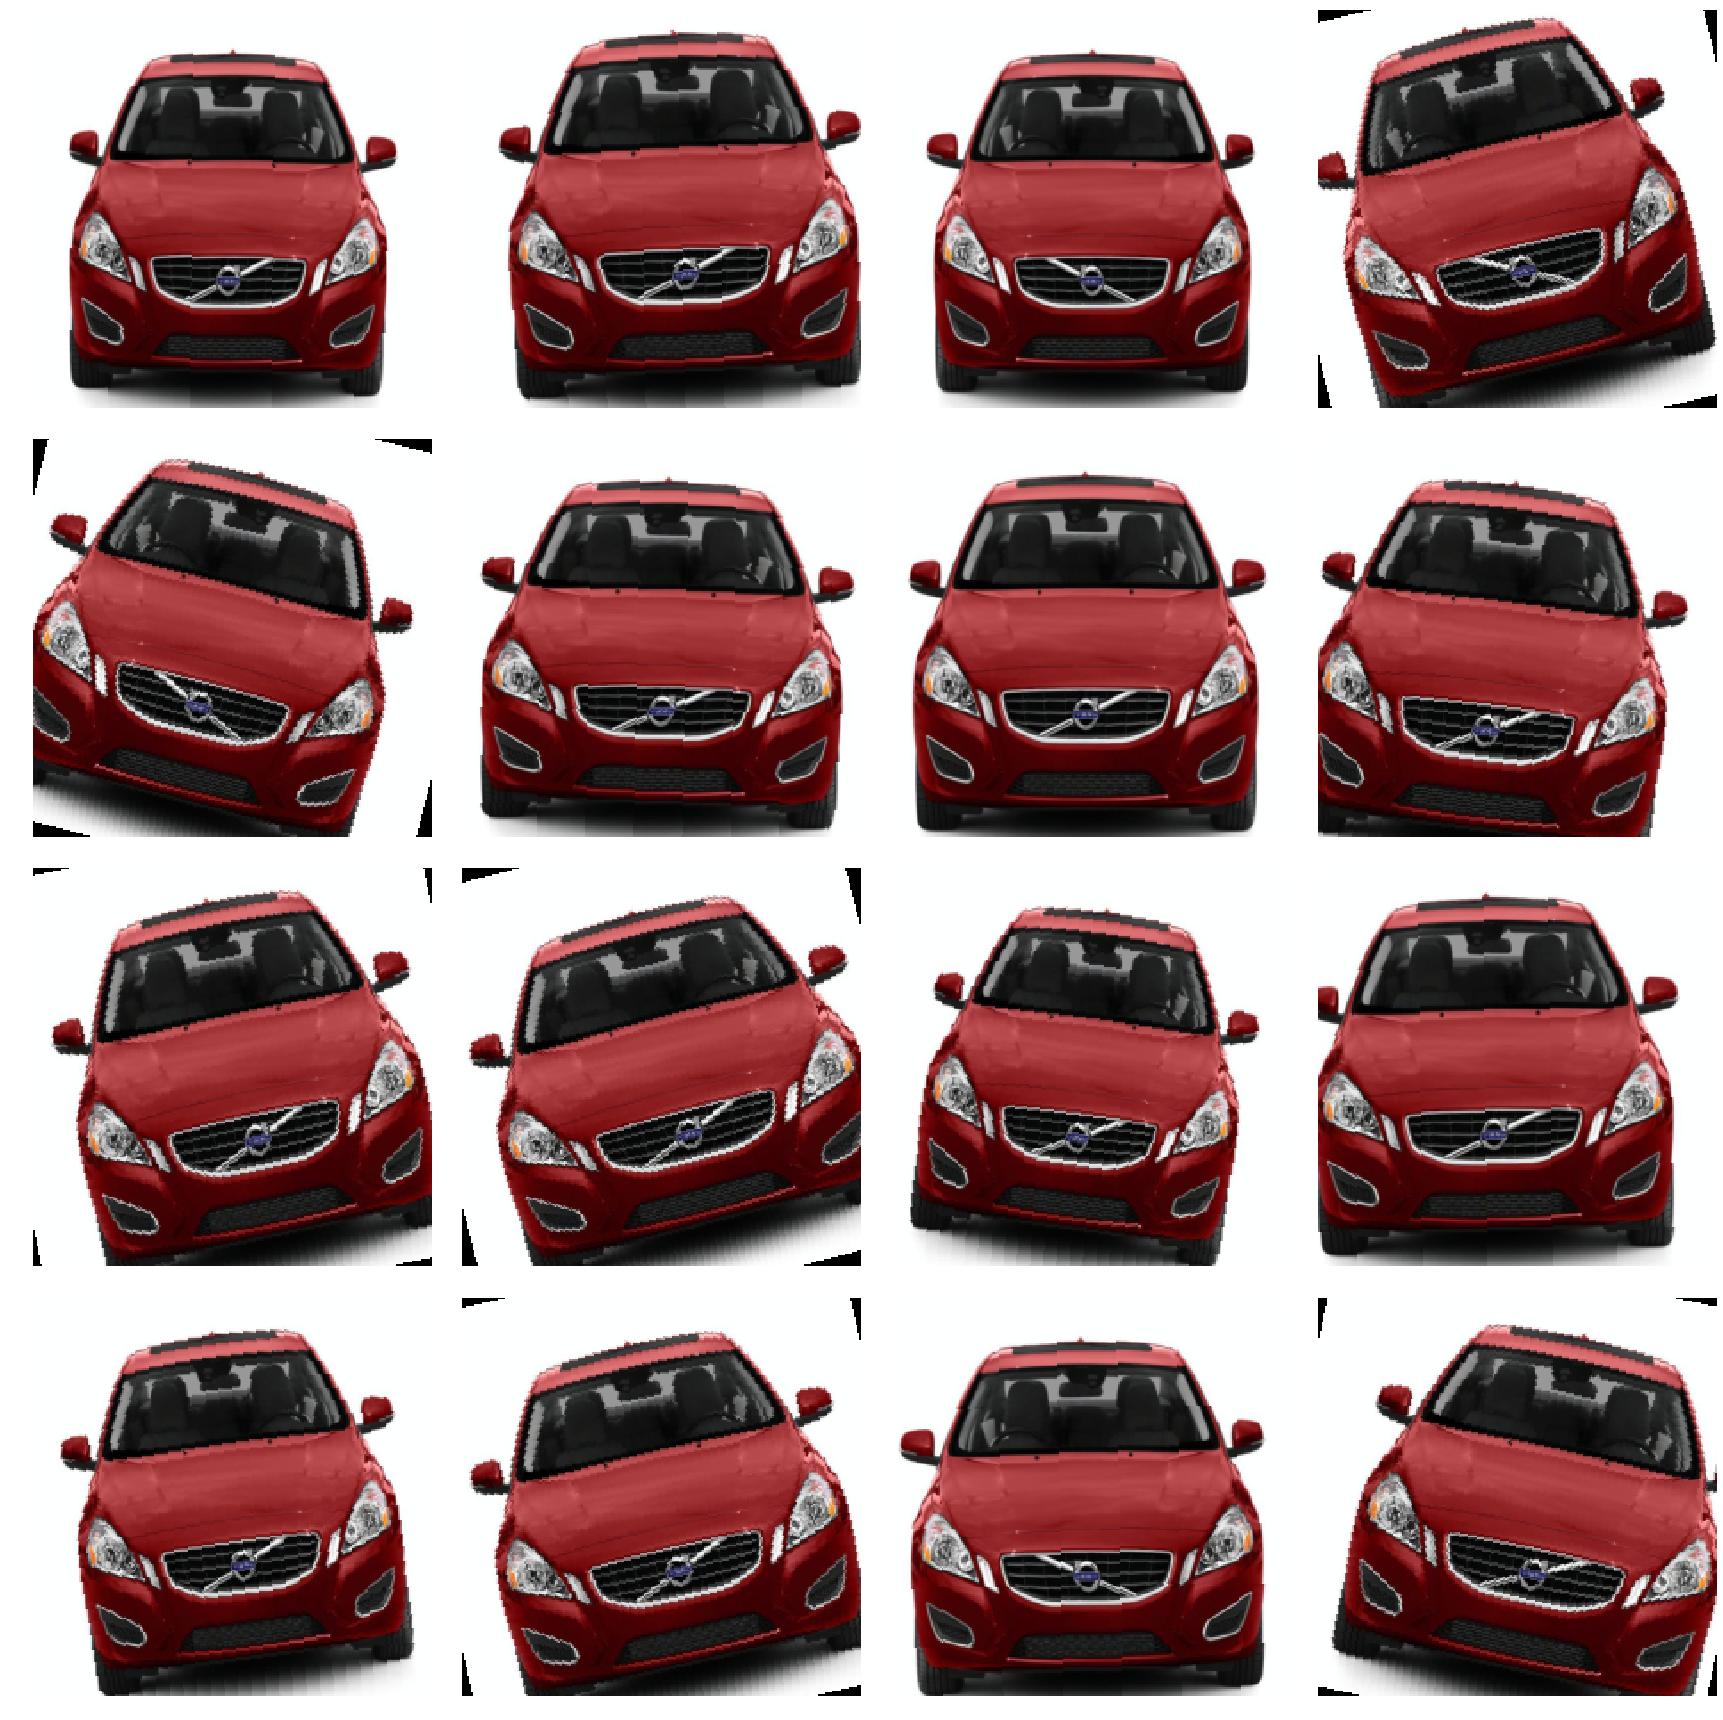

In [10]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

## Section V: Data Iterators

To avoid loading all of the data into memory at once, we use training DataLoaders. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`.

One crucial aspect is to shuffle the data *before* passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch).

In [11]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [12]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([30, 3, 224, 224]), torch.Size([30]))

The shape of a batch is (batch_size, color_channels, height, width).
<br>
There should be 2 different classes. We can confirm this as follows below:

In [13]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

There are 2 different classes.


NOTE: We can iterate through the `DataLoaders` when doing training, validation, and testing. This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. On each epoch, the random transformations will be different so the network will essentially see multiple versions of each training image.

## Section VI: Pre-Trained Models for Image Classification

## About

The idea behind pre-training is the early convolutional layers of a cnn extract features that are relevant for many image recognition tasks. The later, fully-connected layers, specialize to the specific dataset by learning higher-level features. Therefore, we can use the already trained convolutional layers while training only the fully-connected layers on our own dataset. Pre-trained networks have proven to be reasonably successful for a variety of tasks, and result in a significant reduction in training time and usually increases in performance.

In [14]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

NOTE: 
The `classifier` is the part of the model that we'll train. However, for the vgg, we'll only need to train the last few layers in the classifier and not even all of the fully connected layers.


### Freeze Early Layers

We freeze all of the existing layers in the network by setting requires_grad to False.

In [15]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

### Add On a Classifier

We'll train a classifier consisting of the following layers

- Fully connected with ReLU activation (n_inputs, 256)
- Dropout with 40% chance of dropping
- Fully connected with log softmax output (256, n_classes)

To build our custom classifier, we use the nn.Sequential() module which allows us to specify each layer one after the other. We assign our custom classifier to the final classifier layer in the already trained vgg network. When we add on the extra layers, they are set to require_grad=True by default. These will be the only layers that are trained.

In [16]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax()
  )
)

The final output will be log probabilities which we can then use in the Negative Log Likelihood Loss.
<br>
Even with only a few layers set to trainable, there are still over a million parameters (weights) that will be updated during training. In effect, we are fine-tuning the model to work on our problem. We already know it works well on `Imagenet`, and because our images are relatively similar, we should expect the model to easily transfer its knowledge from `Imagenet` to our dataset.

In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
1,049,346 training parameters.


### Move to GPU

To use a gpu in PyTorch, we simply move the whole model onto the gpu. Later we'll have to move the data to gpus in our training loop.
<br>
Since I am using multiple gpus without cuda, I have added the cuda alternative as optional, I also distribute the model across both of them with nn.DataParallel.

In [18]:
#if train_on_gpu:
#    model = model.to('cuda')

#if multi_gpu:
#    model = nn.DataParallel(model)

model = nn.DataParallel(model)

### Function to Load Pre-Trained Model

We can refactor all that code into a single function that returns a pretrained model. This only accepts the vgg16 or resnet50 at the moment but can be extended to use other models. In the output we can see a bird's eye view of our full model, its parameters, and its 42 layers from end to end (top to bottom). This is available for use by the torch summary library.

In [19]:
#Function to Load Pretrained Model:

def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    #if train_on_gpu:
     #   model = model.to('cuda')

    #if multi_gpu:
        model = nn.DataParallel(model)

    return model



model = get_pretrained_model('vgg16')
#if multi_gpu:
#    summary(
#        model.module,
#        input_size=(3, 224, 224),
#        batch_size=batch_size,
#        device='cuda')
#else:
summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')


#if multi_gpu:
#    print(model.module.classifier[6])
#else:
print(model.classifier[6])



model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [30, 64, 224, 224]           1,792
              ReLU-2         [30, 64, 224, 224]               0
            Conv2d-3         [30, 64, 224, 224]          36,928
              ReLU-4         [30, 64, 224, 224]               0
         MaxPool2d-5         [30, 64, 112, 112]               0
            Conv2d-6        [30, 128, 112, 112]          73,856
              ReLU-7        [30, 128, 112, 112]               0
            Conv2d-8        [30, 128, 112, 112]         147,584
              ReLU-9        [30, 128, 112, 112]               0
        MaxPool2d-10          [30, 128, 56, 56]               0
           Conv2d-11          [30, 256, 56, 56]         295,168
             ReLU-12          [30, 256, 56, 56]               0
           Conv2d-13          [30, 256, 56, 56]         590,080
             ReLU-14          [30, 256,

[(0, 'car'), (1, 'nonCar')]

## Section VII: Training Loss and Optimizer

The loss is the negative log likelihood and the optimizer is the Adam optimizer. The negative log likelihood in PyTorch expects log probabilities so we need to pass it the raw output from the log softmax in our model's final layer. The optimizer is told to optimizer the model parameters (only a few of which require a gradient).

- Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
- Optimizer: updates the parameters (weights) with the gradient

In [20]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Optionally, we can look at at the parameters (weights) that will be updated by the optimizer during training.

In [21]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


## Section VIII: Training

For training, we iterate through the train DataLoader, each time passing one batch through the model. One complete pass through the training data is known as an epoch, and we train for a set number of epochs or until early stopping kicks in (more below). After each batch, we calculate the loss (with criterion(output, targets)) and then calculate the gradients of the loss with respect to the model parameters with loss.backward(). This uses autodifferentiation and backpropagation to calculate the gradients.

After calculating the gradients, the function will call optimizer.step() to update the model parameters with the gradients. This is done on each batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as `Adam`). For each batch, we will also compute the accuracy for monitoring and after the training loop has completed, we start the validation loop. This will be used to carry out early stopping, and exit the training process in an efficient manner.

Early stopping is implemented by iterating through the validation data at the end of each training epoch and calculating the loss. We use the complete validation data every time and record whether or not the loss has decreased. If it has not for a number of epochs, we stop training, retrieve the best weights, and return them. When in the validation loop, we make sure not to update the model parameters.

In [22]:
#Training Model:

#--------------------------------------------------------

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history



In [23]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=2)


Starting Training from Scratch.

Epoch: 1	100.00% complete. 287.68 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.0061 	Validation Loss: 0.0031
		Training Accuracy: 100.00%	 Validation Accuracy: 100.00%
Epoch: 3	100.00% complete. 290.25 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0039 	Validation Loss: 0.0028
		Training Accuracy: 99.90%	 Validation Accuracy: 99.84%
Epoch: 5	100.00% complete. 294.02 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0049 	Validation Loss: 0.0079
		Training Accuracy: 99.81%	 Validation Accuracy: 99.68%
Epoch: 7	100.00% complete. 294.85 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0019 	Validation Loss: 0.0025
		Training Accuracy: 99.90%	 Validation Accuracy: 99.84%
Epoch: 9	100.00% complete. 307.24 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.0023 	Validation Loss: 0.0042
		Training Accuracy: 99.90%	 Validation Accuracy: 99.84%

Early Stopping! Total epochs: 9. Best epoch: 4 with loss: 0.00 and acc: 99.84%
4794.20 total s

## Training Results

We can inspect the training progress by looking at the history.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

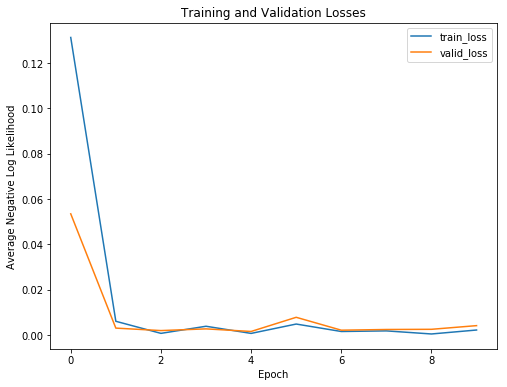

In [24]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')




As expected, the training loss decreases continually with epochs. At a certain point however, the validation loss stops decreasing. There is not a massive amount of overfitting, likely because we were using Dropout and the number of images were small (about 400). With the divergence in losses, there is likely not much more to gain from further training.


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

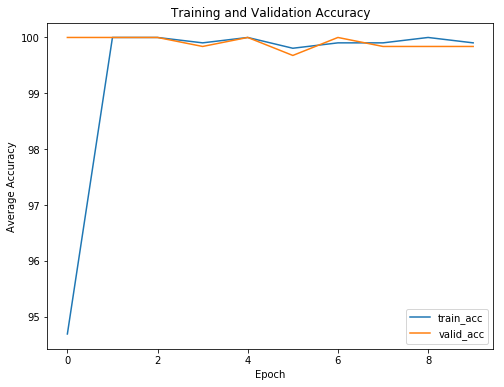

In [25]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')



As with the losses, the training accuracy increases (nearly to perfect) while the validation accuracy plateaus. The model is able to achieve above 90% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.


## Section IX: Saving the Model for Future Use

The train function saves the best model state_dict() which are the weights of the model. To save more information about the model, we use the below function.

In [31]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        #if multi_gpu:
           # checkpoint['classifier'] = model.module.classifier
            # checkpoint['state_dict'] = model.module.state_dict()
        #else:
        checkpoint['classifier'] = model.classifier
        checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        #if multi_gpu:
        #    checkpoint['fc'] = model.module.fc
         #   checkpoint['state_dict'] = model.module.state_dict()
        #else:
        checkpoint['fc'] = model.fc
        checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)


In [32]:
save_checkpoint(model, path=checkpoint_path)

### Load In A CheckPoint

Now we need to write the function to load in the checkpoint. This just takes in a path and returns a model from a saved checkpoint.

In [33]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    #if multi_gpu:
    model = nn.DataParallel(model)

    #if train_on_gpu:
    #    model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer


In [34]:


model, optimizer = load_checkpoint(path=checkpoint_path)

#if multi_gpu:
#    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
#else:
summary(model, input_size=(3, 224, 224), batch_size=batch_size)



135,309,890 total parameters.
1,049,346 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [30, 64, 224, 224]           1,792
              ReLU-2         [30, 64, 224, 224]               0
            Conv2d-3         [30, 64, 224, 224]          36,928
              ReLU-4         [30, 64, 224, 224]               0
         MaxPool2d-5         [30, 64, 112, 112]               0
            Conv2d-6        [30, 128, 112, 112]          73,856
              ReLU-7        [30, 128, 112, 112]               0
            Conv2d-8        [30, 128, 112, 112]         147,584
              ReLU-9        [30, 128, 112, 112]               0
        MaxPool2d-10          [30, 128, 56, 56]               0
           Conv2d-11          [30, 256, 56, 56]         295,168
             ReLU-12          [30, 256, 56, 56]               0
           Conv2d-13          [30, 2



We can now use these two functions to save and load in a complete model. We can use this model to continue training.


In [35]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=3,
    print_every=2)


Model has been trained for: 3 epochs.

Epoch: 1	100.00% complete. 33.72 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.0000 	Validation Loss: 0.0488
		Training Accuracy: 100.00%	 Validation Accuracy: 99.43%
Epoch: 2	100.00% complete. 37.10 seconds elapsed in epoch.
Best epoch: 0 with loss: 0.04 and acc: 99.43%
261.02 total seconds elapsed. 130.51 seconds per epoch.




Further training is unlikely to improve the validation results. Let's move to inference.


## Section X: Performing Inference on Images 

After the model has been trained to the point on no more improvement on validation, we need to test it on data it has never seen. Early stopping with a validation set does decrease overfitting to the training set, but at the cost of potentially overfitting to the validation data. For a final estimate of the model's performance, we need to use the hold out testing data. Here, we'll look at individual predictions along with loss and accuracy on the entire testing dataset.

This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.


In [36]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [37]:
x = process_image(testdir + 'car/car186.jpg')
x.shape

torch.Size([3, 224, 224])

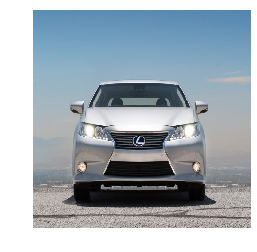

In [38]:
ax, image = imshow_tensor(process_image(testdir + 'car/car186.jpg'))

### A Function to Make Predictions

The next function makes predictions on a single image. It will return the top probabilities and classes.

In [39]:
def predict(image_path, model, topk=2):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class



This function can be used to pick a random test image, below is an example of it at work:


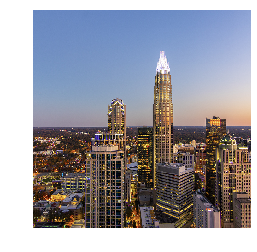

In [40]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [41]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
print(img.shape)

torch.Size([3, 224, 224])


In [42]:
top_p, top_classes, real_class

(array([9.9997568e-01, 2.4555928e-05], dtype=float32),
 ['nonCar', 'car'],
 'nonCar')

In [43]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

(array([1.0000000e+00, 4.2841035e-13], dtype=float32),
 ['car', 'nonCar'],
 'car')

### Function To Display Predictions

This function displays the picture along with the topk predictions from the model. The title over the image displays the true class.

In [44]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

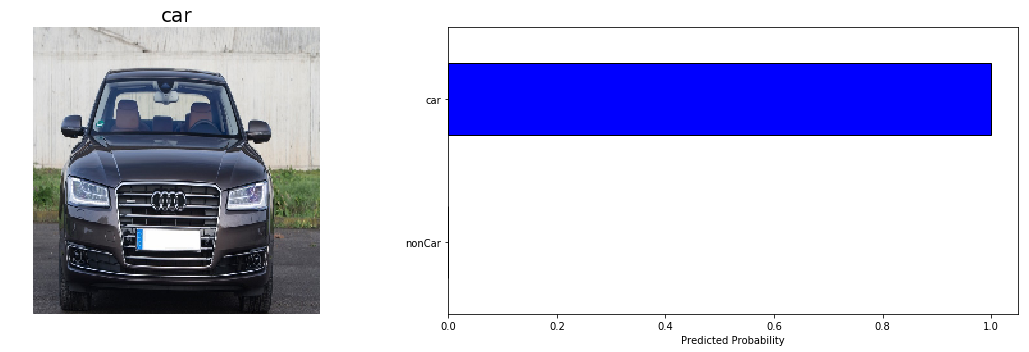

In [45]:
display_prediction(random_test_image(), model, topk=2)

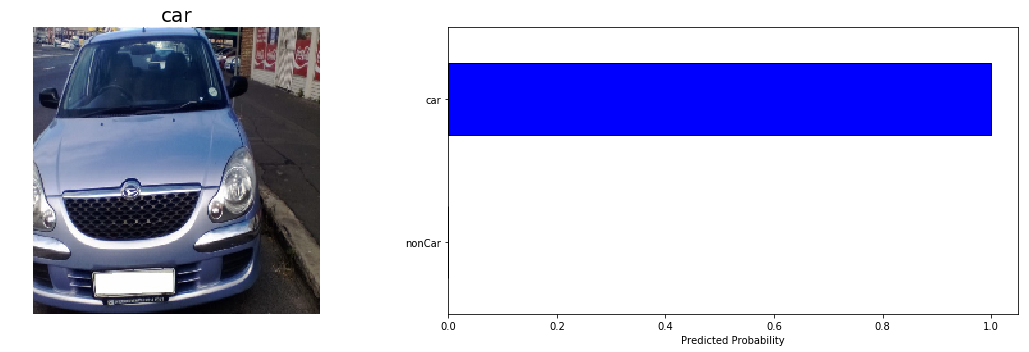

In [46]:
display_prediction(random_test_image(), model, topk=2)

### Testing Accuracy

We'll assess out model by the top1 and top5 accuracy, that is, the percentage of predictions it gets exactly correct, and the percentage of predictions where the real class is in the top 5 actual classes (in this application, just the top 2).

The function below computes accuracy for a prediction and a target in terms of topk.


In [50]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [51]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 2))
else:
    accuracy(model(features), targets, topk=(1, 2))

[100.0, 100.0]

### Function to Evaluate the Model Over All Classes

The next function iterates through the testing set in order to make predictions for each image. It calculates performance for each category.

In [54]:
def evaluate(model, test_loader, criterion, topk=(1, 2)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [55]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()


,class,top1,top2,loss
0,car,100.0,100.0,5.990417e-08
1,nonCar,100.0,100.0,2.377014e-03


### Test Results

Text(0.5, 6.800000000000011, 'images')

Text(3.6750000000000043, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Top 1 Accuracy vs Number of Training Images')

(-5, 105)

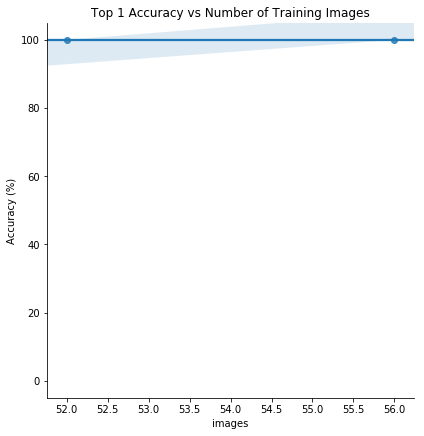

In [56]:
results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [57]:
print('Category with minimum accuracy.')
results.loc[results['top1'].idxmin]

print('Category with minimum images.')
results.loc[results['n_train'].idxmin]

Category with minimum accuracy.


class              car
top1               100
top2               100
loss       5.99042e-08
n_train             52
n_valid             54
n_test             200
Name: 0, dtype: object

Category with minimum images.


class              car
top1               100
top2               100
loss       5.99042e-08
n_train             52
n_valid             54
n_test             200
Name: 0, dtype: object

Text(0.5, 6.800000000000011, 'images')

Text(3.6750000000000043, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Top 2 Accuracy vs Number of Training Images')

(-5, 105)

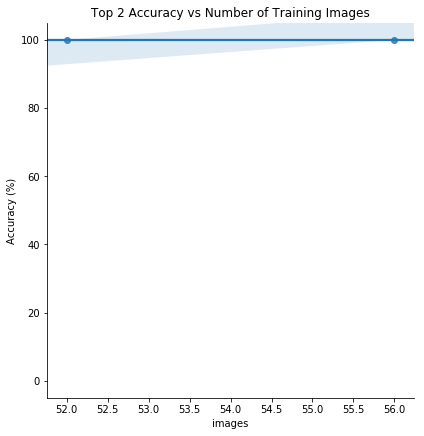

In [61]:
sns.lmplot(
    y='top2', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 2 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)



In [64]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 2):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']

# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
loss_weighted = (results['weighted'] * results['loss']).sum()

print(f'Final test cross entropy per image = {loss_weighted:.4f}.')
print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')

Final test cross entropy per image = 0.0007.
Final test top 1 weighted accuracy = 100.00%


## Conclusions

This project taught us the basics of using PyTorch and pretrained neural networks for image recognition. We saw how to take a network that was trained on a large set of images and apply it successfully to a different task. Along the way, we learned a number of useful concepts for working with cnns in PyTorch including how to get our data into a model. The end result is a capable model trained in far less time than one trained from starting weights.

Some of the ideas covered in this notebook were:

- PyTorch basics
- Data transformations
- Training data augmentation
- Transfer Learning for object recognition
- Training a PyTorch model with early stopping on a validation set
- Inference using a PyTorch model

Truly, we live in an incredible age for deep learning with the wide availability of resources, and it's only getting better! Hopefully, this notebook has prepared you to take on your own deep learning challenges with PyTorch.